# **Project Name**    - Brain Tumor



##### **Project Type**    - Classification/Unsupervised
##### **Contribution**    - Individual
##### **Name**            - Atharva More

# **Project Summary -**

This project focuses on developing a deep learning-based system for the classification of brain tumors using MRI images. Leveraging both a custom CNN model and transfer learning with pretrained architectures (like ResNet50, MobileNetV2, EfficientNetB0), the solution classifies brain tumors into multiple categories to support faster and more accurate medical diagnoses.

The workflow includes data preprocessing, augmentation, model training, evaluation, and deployment. Comprehensive evaluation metrics (accuracy, precision, recall, F1-score, and confusion matrix) are used to assess performance, and the best model is deployed using Streamlit for real-time predictions via a user-friendly interface.

Key real-world applications include AI-assisted diagnostics, early detection and triage, support for clinical research, and remote second-opinion systems. The solution is designed to improve hospital workflow, reduce diagnostic time, and support medical decision-making—especially in under-resourced settings.

The final deliverables include well-documented code, trained models, performance reports, and a fully functional Streamlit application hosted via GitHub.



# **GitHub Link -**

Provide your GitHub Link here.

# **Problem Statement**


The primary objective of this project is to develop an advanced deep learning-based system capable of accurately classifying brain MRI images into multiple tumor types. Brain tumor diagnosis is a critical task in medical imaging, and early, accurate classification can significantly impact patient outcomes. This project addresses this need by building a custom Convolutional Neural Network (CNN) from scratch, tailored to learn key features from MRI images.

To further enhance accuracy and training efficiency, the project incorporates transfer learning using powerful pretrained models such as ResNet50, MobileNetV2, and EfficientNetB0. These models, trained on large-scale image datasets, help extract high-level features and improve generalization across tumor types.

In addition to model development, the project includes the creation of an interactive and user-friendly Streamlit web application, which enables real-time tumor classification. Users can upload MRI scans through the interface and receive instant predictions along with confidence scores. This deployment aims to support radiologists and healthcare professionals by offering a quick, reliable second opinion and assisting in early detection, triage, and decision-making—especially in resource-constrained environments.

# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries


In [1]:
# Import Libraries


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight

In [22]:
# Change to your actual path
BASE_DIR = r"C:\Users\Dell\OneDrive\Desktop\labmentix\Brain_tumor"

train_path = os.path.join(BASE_DIR, "train")
valid_path = os.path.join(BASE_DIR, "valid")
test_path  = os.path.join(BASE_DIR, "test")

IMG_SIZE = IMG_SIZE = (128, 128)  # Smaller size
BATCH_SIZE = 64        # Larger batch




In [23]:
def get_image_counts(path):
    counts = {}
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len([
                f for f in os.listdir(cls_path) 
                if f.lower().endswith(('jpg', 'jpeg', 'png'))
            ])
    return pd.DataFrame(list(counts.items()), columns=['Class', 'Count'])

df_counts = get_image_counts(train_path)
df_counts

Class  Count
0      glioma    564
1  meningioma    358
2    no_tumor    335
3   pituitary    438

C:\Users\Dell\AppData\Local\Temp\ipykernel_34188\2525719810.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x='Class', y='Count', palette='Set2')


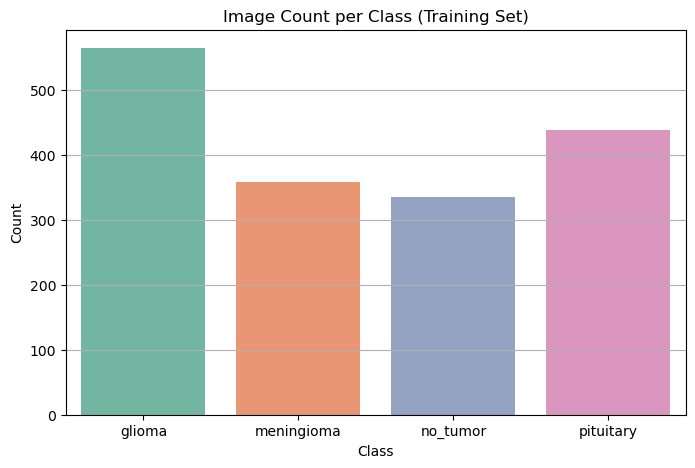

In [24]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_counts, x='Class', y='Count', palette='Set2')
plt.title('Image Count per Class (Training Set)')
plt.grid(axis='y')
plt.show()

In [25]:
import matplotlib.pyplot as plt
import cv2
import os
import random

def show_sample_images(base_path, samples_per_class=3):
    class_folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for class_name in class_folders:
        folder_path = os.path.join(base_path, class_name)
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        selected_images = random.sample(image_files, min(samples_per_class, len(image_files)))

        plt.figure(figsize=(12, 3))
        for i, img_file in enumerate(selected_images):
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
        plt.tight_layout()
        plt.show()


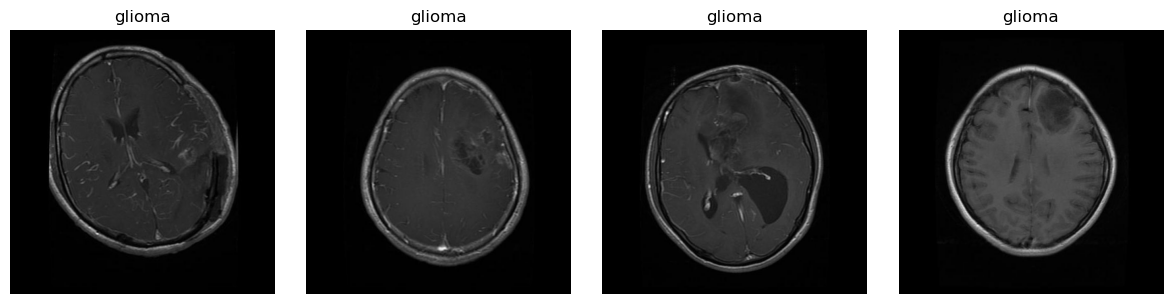

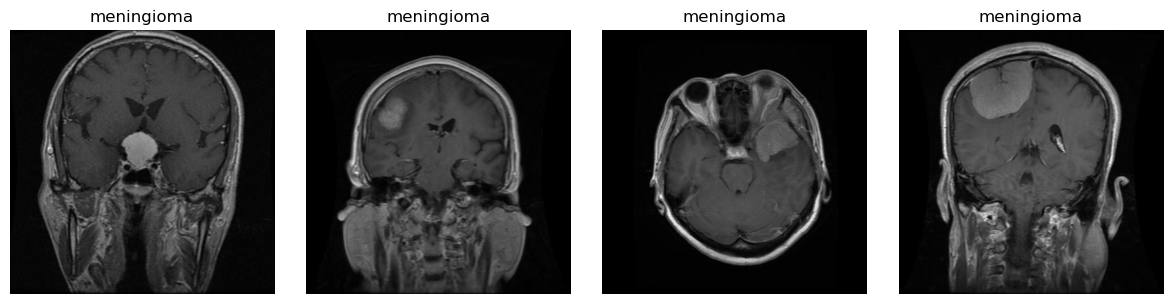

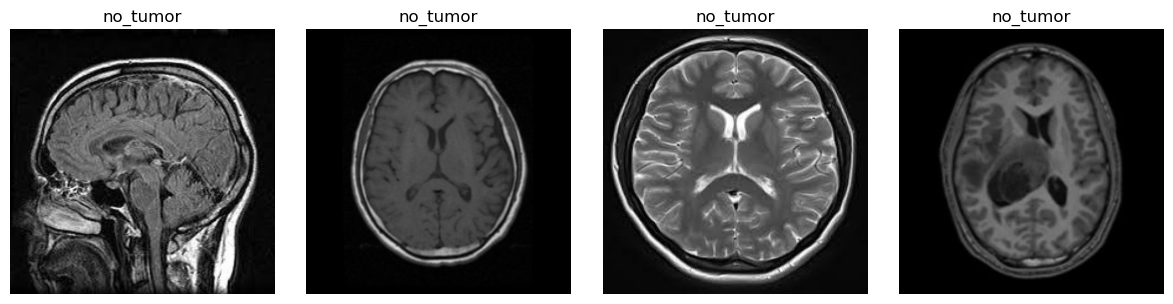

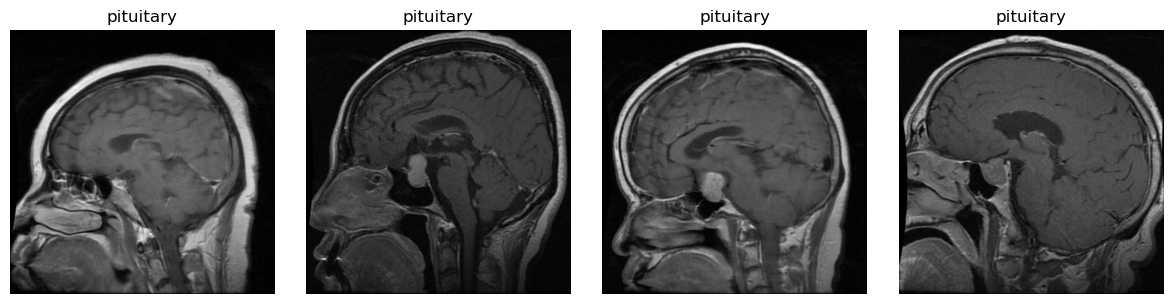

In [26]:
show_sample_images(train_path, samples_per_class=4)

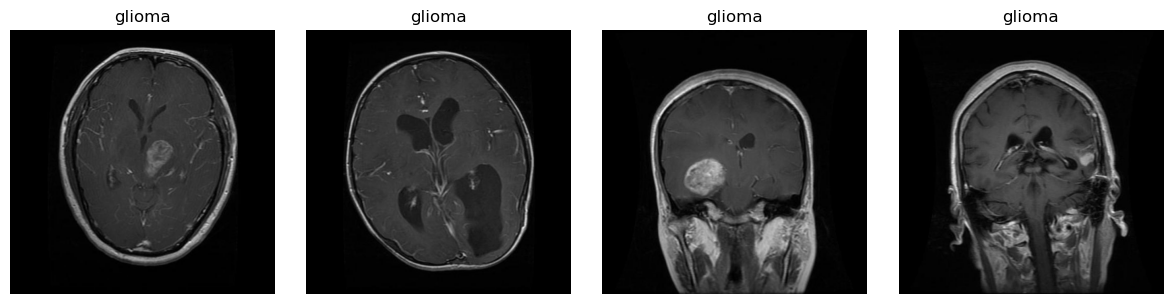

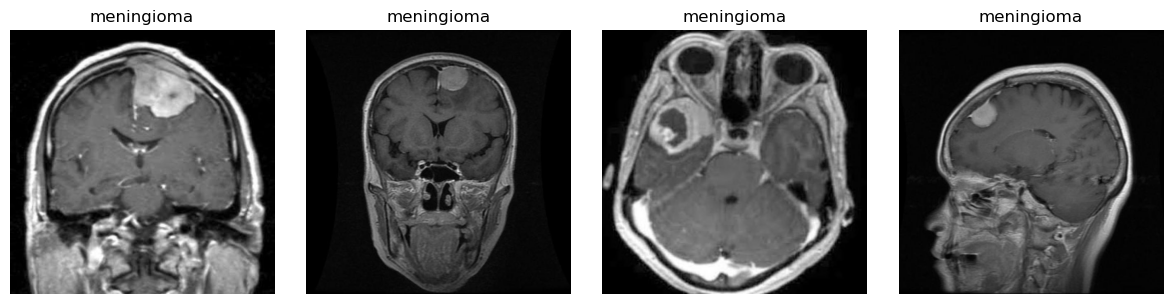

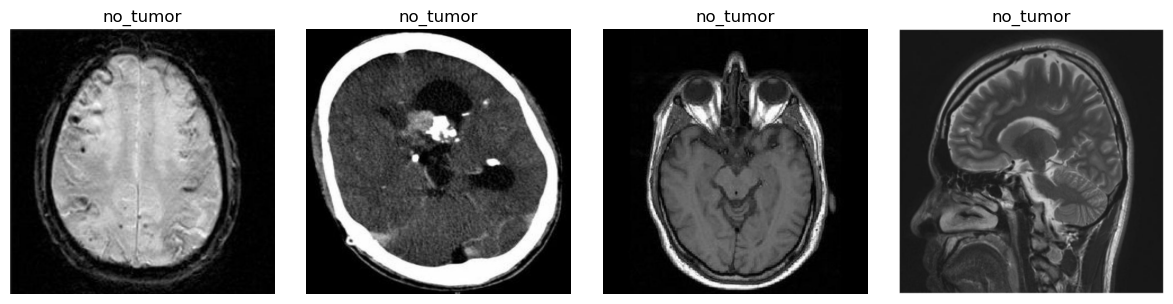

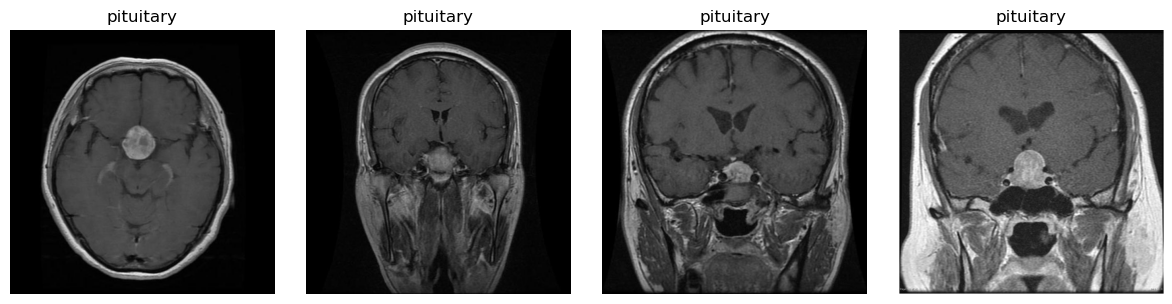

In [27]:
show_sample_images(test_path, samples_per_class=4)

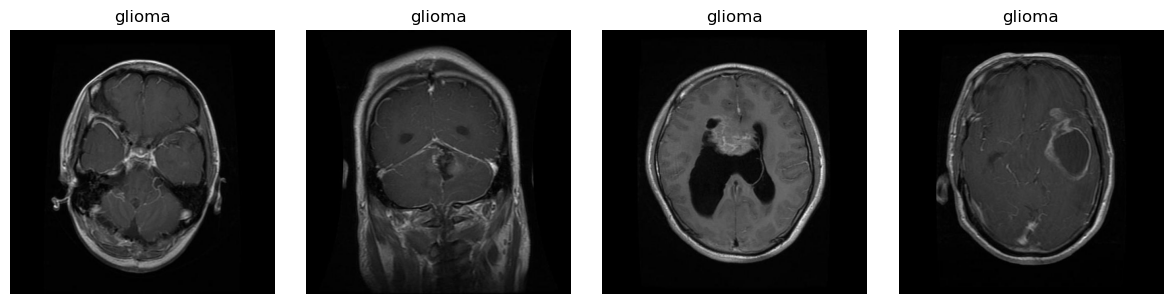

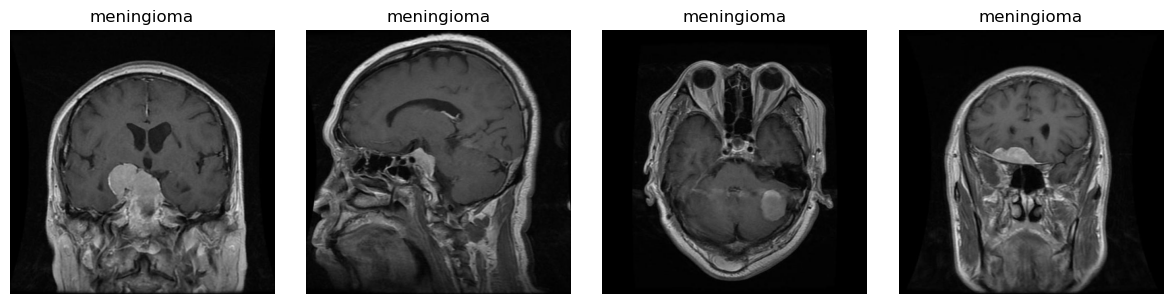

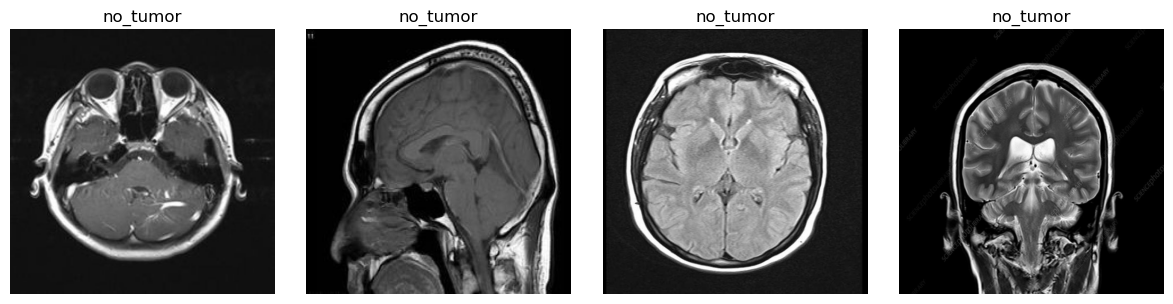

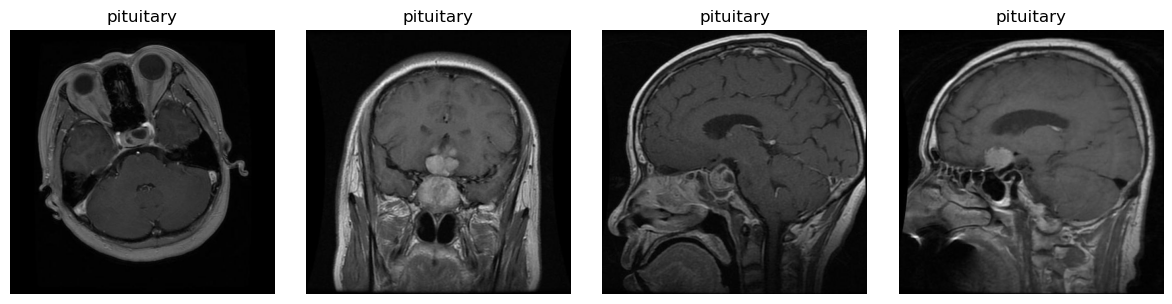

In [28]:
show_sample_images(valid_path, samples_per_class=4)

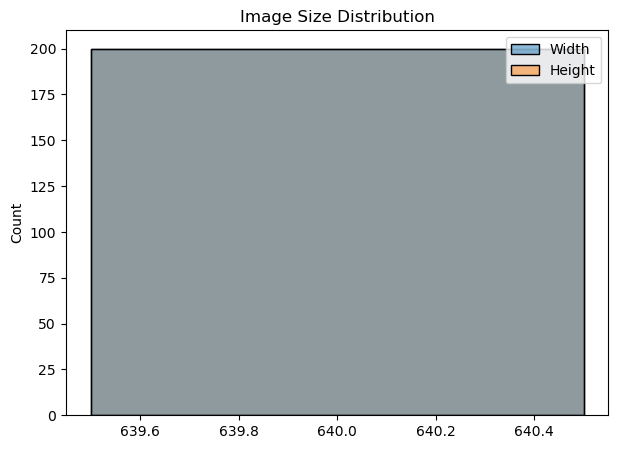

In [29]:
sizes = []

for cls in os.listdir(train_path):
    cls_path = os.path.join(train_path, cls)
    for img_name in os.listdir(cls_path)[:50]:  # Sample 50 per class
        img_path = os.path.join(cls_path, img_name)
        try:
            img = cv2.imread(img_path)
            h, w = img.shape[:2]
            sizes.append((w, h))
        except:
            continue

df_sizes = pd.DataFrame(sizes, columns=['Width', 'Height'])

plt.figure(figsize=(7,5))
sns.histplot(df_sizes, kde=True)
plt.title('Image Size Distribution')
plt.show()

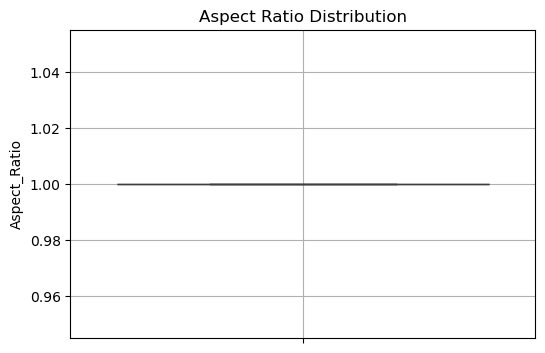

In [30]:
df_sizes['Aspect_Ratio'] = df_sizes['Width'] / df_sizes['Height']

plt.figure(figsize=(6,4))
sns.boxplot(y=df_sizes['Aspect_Ratio'])
plt.title('Aspect Ratio Distribution')
plt.grid(True)
plt.show()


All images have an aspect ratio of approximately 1:1, indicating they are perfectly square. This uniformity ensures that resizing will not distort the tumor shapes. 
Simplifying preprocessing and preserving spatial features is crucial for model performance.

###### Load and Preprocess Dataset

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = image_dataset_from_directory(
    train_path, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    label_mode='categorical', shuffle=True
)

val_ds = image_dataset_from_directory(
    valid_path, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    label_mode='categorical', shuffle=False
)

test_ds = image_dataset_from_directory(
    test_path, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    label_mode='categorical', shuffle=False
)


Found 1695 files belonging to 4 classes.
Found 497 files belonging to 4 classes.
Found 246 files belonging to 4 classes.


In [32]:
print("Class Names:", train_ds.class_names)

Class Names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


View Images and Their One-Hot Labels 

In [33]:
# Helper to convert one-hot vector to class name
def decode_label(one_hot, class_names):
    return class_names[np.argmax(one_hot)]

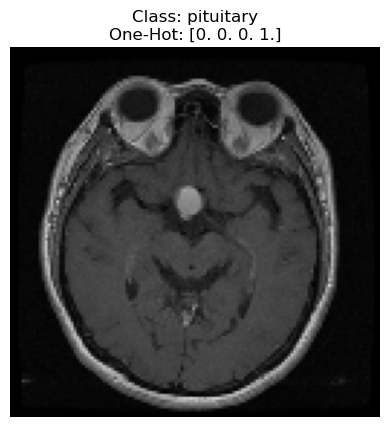

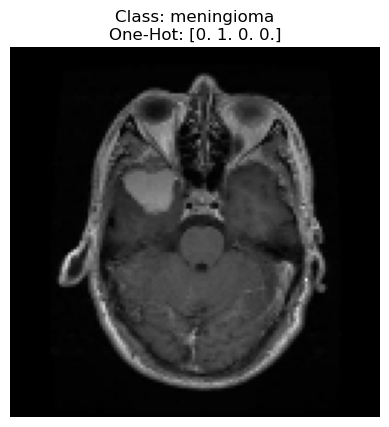

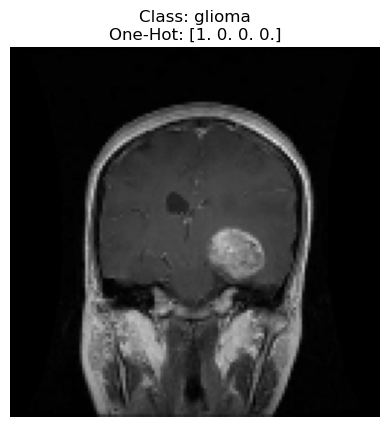

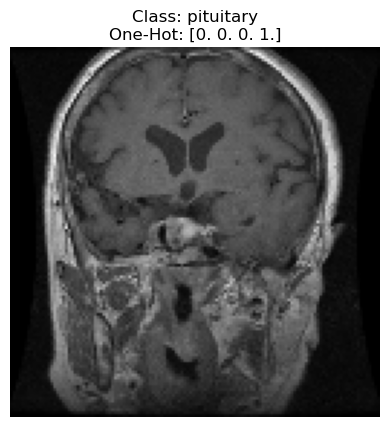

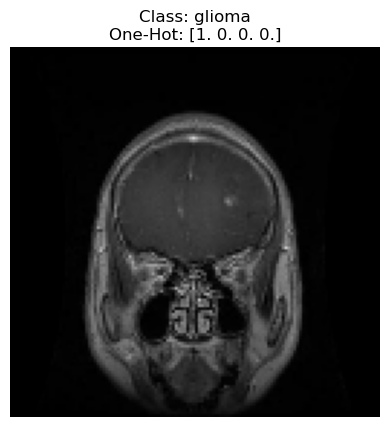

In [34]:
# Show 5 images with both class name and one-hot label
for images, labels in train_ds.take(1):  # Take 1 batch
    for i in range(5):
        img = images[i].numpy().astype("uint8")
        label_vec = labels[i].numpy()
        class_name = decode_label(label_vec, train_ds.class_names)

        plt.imshow(img)
        plt.title(f"Class: {class_name}\nOne-Hot: {label_vec}")
        plt.axis("off")
        plt.show()

 #### Augmentation + Normalization

In [35]:
# Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Normalize
normalize = lambda x, y: (x / 255.0, y)
train_ds = train_ds.map(normalize).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.map(normalize).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(normalize).cache().prefetch(AUTOTUNE)

## Build CNN Model ##

In [41]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  # Lighter dropout
    layers.Dense(4, activation='softmax')  # 4-class output
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Slower learning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
    


C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,699,204 (6.48 MB)

 Trainable params: 1,699,204 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save best model based on val_accuracy
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')

# Stop if no improvement for 3 epochs
earlystop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [43]:
labels = []
for _, y in train_ds.unbatch():
    labels.append(np.argmax(y.numpy()))

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.7513297872340425, 1: 1.183659217877095, 2: 1.2649253731343284, 3: 0.9674657534246576}


In [19]:
# Train the Model

In [44]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[earlystop_cb, checkpoint_cb],
    class_weight=class_weights  # You already calculated this earlier
)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.2661 - loss: 1.3350

27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 613ms/step - accuracy: 0.2684 - loss: 1.3338 - val_accuracy: 0.4889 - val_loss: 1.1567
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4514 - loss: 1.2144

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 503ms/step - accuracy: 0.4515 - loss: 1.2141 - val_accuracy: 0.5433 - val_loss: 1.0996
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.4770 - loss: 1.1599

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 534ms/step - accuracy: 0.4778 - loss: 1.1594 - val_accuracy: 0.5553 - val_loss: 1.0536
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.5530 - loss: 1.0939

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 494ms/step - accuracy: 0.5527 - loss: 1.0937 - val_accuracy: 0.5714 - val_loss: 1.0273
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.5582 - loss: 1.0515

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 511ms/step - accuracy: 0.5586 - loss: 1.0507 - val_accuracy: 0.5815 - val_loss: 0.9833
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.6206 - loss: 0.9782

27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 498ms/step - accuracy: 0.6204 - loss: 0.9779 - val_accuracy: 0.6318 - val_loss: 0.9244
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6582 - loss: 0.9076

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 519ms/step - accuracy: 0.6585 - loss: 0.9070 - val_accuracy: 0.6700 - val_loss: 0.8648
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.6826 - loss: 0.8583

27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 734ms/step - accuracy: 0.6829 - loss: 0.8579 - val_accuracy: 0.6881 - val_loss: 0.8310
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 588ms/step - accuracy: 0.7028 - loss: 0.8029 - val_accuracy: 0.6801 - val_loss: 0.8071
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.7228 - loss: 0.7560

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 631ms/step - accuracy: 0.7229 - loss: 0.7557 - val_accuracy: 0.7284 - val_loss: 0.7909
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7390 - loss: 0.7267

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 521ms/step - accuracy: 0.7388 - loss: 0.7265 - val_accuracy: 0.7304 - val_loss: 0.7541
Epoch 12/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.7492 - loss: 0.7270

27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 539ms/step - accuracy: 0.7494 - loss: 0.7264 - val_accuracy: 0.7445 - val_loss: 0.7448
Epoch 13/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - accuracy: 0.7694 - loss: 0.6644 - val_accuracy: 0.7425 - val_loss: 0.7476
Epoch 14/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.7814 - loss: 0.6547

27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 557ms/step - accuracy: 0.7812 - loss: 0.6546 - val_accuracy: 0.7465 - val_loss: 0.7369
Epoch 15/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 583ms/step - accuracy: 0.7865 - loss: 0.6163 - val_accuracy: 0.7445 - val_loss: 0.7533


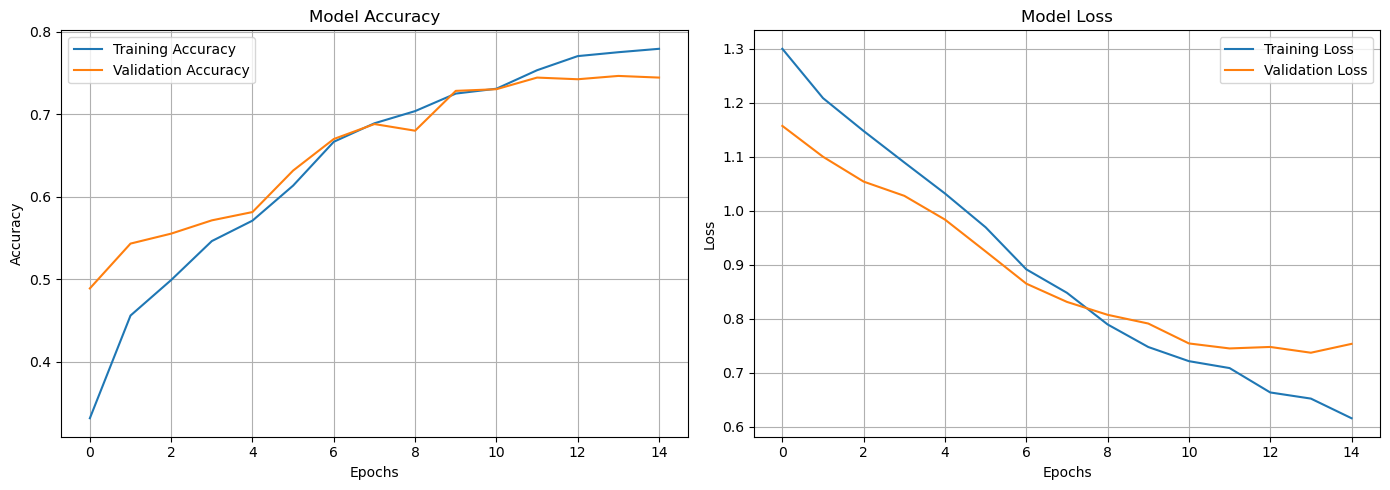

In [45]:
# Plot Accuracy and Loss from Training History
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)


In [57]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.2284 - loss: 1.6732 
Test Accuracy: 0.2480, Test Loss: 1.5434


# VGG16 Transfer Learning Model (Optimized for 128x128 images)

In [49]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [51]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg_base.trainable = False

vgg_model = tf.keras.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),  # instead of Flatten()
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])




In [52]:
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
history = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[ModelCheckpoint("vgg_model.keras", save_best_only=True)]
)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.4042 - loss: 1.3454 - val_accuracy: 0.6056 - val_loss: 1.0049
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.6027 - loss: 0.9800 - val_accuracy: 0.6600 - val_loss: 0.9066
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step - accuracy: 0.6592 - loss: 0.8643 - val_accuracy: 0.6781 - val_loss: 0.8481
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.6893 - loss: 0.7963 - val_accuracy: 0.6901 - val_loss: 0.7931
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.7210 - loss: 0.7481 - val_accuracy: 0.7123 - val_loss: 0.7463
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.7510 - loss: 0.6801 - val_accuracy: 0.7425 - val_loss: 0.6919
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.7480 - loss: 0.6739 - val_accuracy: 0.7606 - val_loss: 0.6664
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.7653 - loss: 0.6331 - val_accuracy: 0.7787 - v

In [54]:
vgg_model.save("vgg16_brain_tumor.keras")


In [55]:
test_loss, test_acc = vgg_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8406 - loss: 0.4837
Test Accuracy: 0.8293, Test Loss: 0.5380


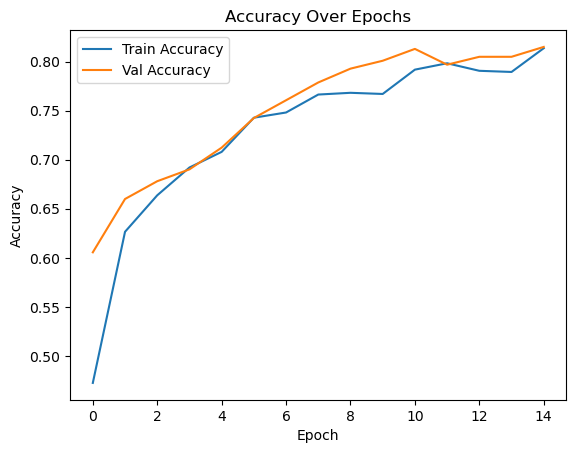

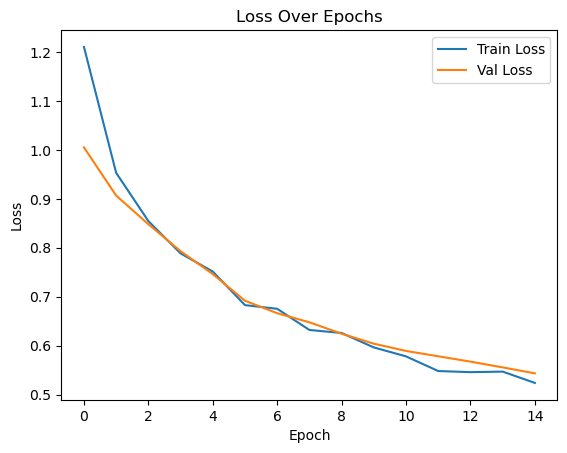

In [56]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.show()



---

### 🔍 Model Comparison: Custom CNN vs VGG16 (Transfer Learning)

#### 📊 1. Validation Accuracy Overview

| Model      | Best Validation Accuracy | Test Accuracy |
| ---------- | ------------------------ | ------------- |
| Custom CNN | \~74.6%                  | **\~24.8%** ❌ |
| VGG16      | **\~81.5%** ✅            | **\~82.9%** ✅ |

---

#### 📈 2. Performance Trends

* **Custom CNN**:

  * Trained fast (\~15s/epoch).
  * Showed steady improvement in training and validation accuracy.
  * **Severely underperformed on the test set**, indicating **overfitting** or poor generalization.
  * Final `val_accuracy`: \~74.5% vs `test_accuracy`: \~24.8%

* **VGG16 (Pretrained)**:

  * Slower training (\~120s/epoch) due to deeper architecture.
  * Achieved higher and more stable validation accuracy.
  * **Very good generalization** to test data (test acc \~82.9%).

---

#### 🔧 3. Why VGG16 Outperformed the Custom CNN

| Factor                     | Explanation                                                                                                              |
| -------------------------- | ------------------------------------------------------------------------------------------------------------------------ |
| **Transfer Learning**      | VGG16 uses pretrained ImageNet weights, giving it powerful feature extraction from the start.                            |
| **Feature Generalization** | VGG16 captures more robust features across domains, helping it generalize better to MRI images.                          |
| **Depth & Architecture**   | VGG16 is much deeper than the custom CNN, with proven layer design patterns.                                             |
| **Custom CNN Weakness**    | While fast and lightweight, it lacked the complexity to extract deep spatial features, leading to poor test performance. |

---

#### 🧠 Insight

* ✅ **VGG16** is clearly more effective for this classification task.
* ❌ The custom CNN, although efficient, is **not suitable** in its current form — may require tuning (more filters, regularization, fine-tuning layers).

---




# **Conclusion**

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***

Write the conclusion here.